# Вторая неделя


#### Выполнил Ким Антон 
#### В рамках курса "Введение в машинное обучение" от Высшей школы экономики

## I. Выбор числа соседей

### Введение
Метрические методы основаны на гипотезе компактности, суть которой состоит в том, что объекты с похожими признаковыми описаниями имеют похожие значения целевой переменной. Если эта гипотеза верна, то строить прогноз для нового объекта можно на основе близких к нему объектов из обучающей выборки — например, путем усреднения их ответов (для регрессии) или путем выбора наиболее популярного среди них класса (для классификации). Методы такого типа и называются метрическими. Они имеют несколько особенностей:
<ul>
<li>Процедура обучения, по сути, отсутствует — достаточно лишь запомнить все объекты обучающей выборки</li>
<li>Можно использовать метрику, учитывающую особенности конкретного набора данных — например, наличие категориальных (номинальных) признаков</li>
<li>При правильном выборе метрики и достаточном размере обучающей выборки метрические алгоритмы показывают качество, близкое к оптимальному</li>
</ul>
Метрические методы чувствительны к масштабу признаков — так, если масштаб одного из признаков существенно превосходит масштабы остальных признаков, то их значения практически не будут влиять на ответы алгоритма. Поэтому важно производить масштабирование признаков. Обычно это делается путем вычитания среднего значения признака и деления на стандартное отклонение.

### План работы
<ul>
 <li>работать с методом k ближайших соседей</li>
 <li>выбирать в нем параметр k</li>
 <li>правильно готовить данные к использованию в методе kNN</li>
</ul>

### Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

### Загрузка данных 

In [2]:
data = pd.read_csv('data/week_2_wine.data', header=None)

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       178 non-null    int64  
 1   1       178 non-null    float64
 2   2       178 non-null    float64
 3   3       178 non-null    float64
 4   4       178 non-null    float64
 5   5       178 non-null    int64  
 6   6       178 non-null    float64
 7   7       178 non-null    float64
 8   8       178 non-null    float64
 9   9       178 non-null    float64
 10  10      178 non-null    float64
 11  11      178 non-null    float64
 12  12      178 non-null    float64
 13  13      178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


### Описание данных

<ol>
    <li><b>Alcohol</b></li>
    <li><b>Malic acid</b></li>
    <li><b>Ash</b></li>
    <li><b>Alcalinity of ash</b></li>
    <li><b>Magnesium</b></li>
    <li><b>Total phenols</b></li>
    <li><b>Flavanoids</b></li>
    <li><b>Nonflavanoid phenols</b></li>
    <li><b>Proanthocyanins</b></li>
    <li><b>Color intensity</b></li>
    <li><b>Hue</b></li>
    <li><b>OD280/OD315 of diluted wines</b></li>
    <li><b>Proline</b></li>
</ol>


### Инструкции по выполнению
Метод k ближайших соседей реализован в классе ``sklearn.neighbors.KNeighborsClassifier``. Основным параметром является **n_neighbors**, который задает число соседей для построения прогноза.

Вам понадобится производить кросс-валидацию по блокам. **Кросс-валидация** заключается в разделении выборки на m непересекающихся блоков примерно одинакового размера, после чего выполняется m шагов. На i-м шаге i-й блок выступает в качестве тестовой выборки, объединение всех остальных блоков — в качестве обучающей выборки. Соответственно, на каждом шаге алгоритм обучается на некоторой обучающей выборке, после чего вычисляется его качество на тестовой выборке. После выполнения m шагов мы получаем m показателей качества, усреднение которых и дает оценку кросс-валидации.

Технически кросс-валидация проводится в два этапа:

1. Создается генератор разбиений ``sklearn.model_selection.KFold``, который задает набор разбиений на обучение и валидацию. Число блоков в кросс-валидации определяется параметром **n_splits**. Обратите внимание, что порядок следования объектов в выборке может быть неслучайным, это может привести к смещенности кросс-валидационной оценки. Чтобы устранить такой эффект, объекты выборки случайно перемешивают перед разбиением на блоки. Для перемешивания достаточно передать генератору KFold параметр **shuffle=True**.


2. Вычислить качество на всех разбиениях можно при помощи функции `sklearn.model_selection.cross_val_score`. В качестве параметра **estimator** передается классификатор, в качестве параметра **cv** — генератор разбиений с предыдущего шага. С помощью параметра **scoring** можно задавать меру качества, по умолчанию в задачах классификации используется доля верных ответов (**accuracy**). Результатом является массив, значения которого **нужно усреднить**.


Приведение признаков к одному масштабу можно делать с помощью функции `sklearn.preprocessing.scale`, которой на вход необходимо подать матрицу признаков и получить масштабированную матрицу, в которой каждый столбец имеет нулевое среднее значение и единичное стандартное отклонение.

#### 1. Извлеките из данных признаки и классы. Класс записан в первом столбце

In [5]:
y = data[0]
X = data.drop(0, axis=1)
X.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### 2. Оценку качества необходимо провести методом кросс-валидации по 5 блокам. В качестве меры качества используйте долю верных ответов (accuracy)

In [6]:
cv = KFold(shuffle=True, random_state=42,)
model = KNeighborsClassifier(n_jobs=-1)
cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1).mean()

0.6746031746031746

**accuracy** score - 67.5%

#### 3. Найдите точность классификации на кросс-валидации для метода k ближайших соседей, при k от 1 до 50. При каком k получилось оптимальное качество? Чему оно равно? 

In [7]:
cv = KFold(shuffle=True, random_state=42,)
model = KNeighborsClassifier(n_jobs=-1)
params = {'n_neighbors':np.arange(1,51)}
grid = GridSearchCV(model,param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1)

In [8]:
%%time
grid.fit(X, y)

Wall time: 1.25 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [9]:
grid.best_params_, grid.best_score_

({'n_neighbors': 1}, 0.7304761904761905)

После проведения кросс-валидации, лучшим значением оказалос **1** при значении точности **73%**

##### 4. Произведите масштабирование признаков. Снова найдите оптимальное k на кросс-валидации. Какое значение k получилось оптимальным после приведения признаков к одному масштабу?

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
%%time
grid.fit(X, y)

Wall time: 621 ms


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [12]:
grid.best_params_, grid.best_score_

({'n_neighbors': 29}, 0.9776190476190475)

После проведения **масштабирования** признаков, модель значительно улучшила свою точность **98%**, также изменился лучшее значение параметра **29**

## II. Выбор метрики

### Введение
Главным параметром любого метрического алгоритма является **функция расстояния (или метрика)**, используемая для измерения сходства между объектами. Можно использовать стандартный вариант (например, евклидову метрику), но гораздо более эффективным вариантом является **подбор метрики под конкретную задачу**. Один из подходов — использование той же евклидовой метрики, но с **весами**: каждой координате ставится в соответствие определенный коэффициент; **чем он больше, тем выше вклад признака** в итоговое расстояние. Веса настраиваются с целью оптимизации качества на отложенной выборке. Другой подход, о котором и пойдет речь в данном задании — **выбор метрики из некоторого класса метрик**. Мы возьмем за основу метрику **Минковского**. Параметром метрики Минковского является число **p**, которое мы и будем настраивать.

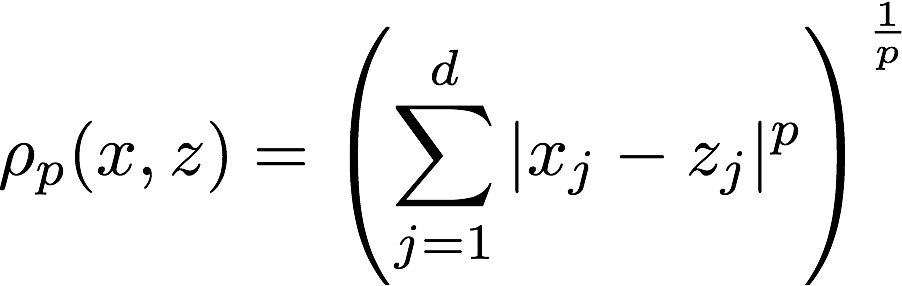

### План работы
<ul>
 <li>выбирать оптимальную метрику из параметрического семейства</li>
</ul>

### Подключение библиотек

In [13]:
from sklearn.datasets import load_boston
from sklearn.neighbors import KNeighborsRegressor

### Загрузка данных 

In [14]:
X, y = load_boston(return_X_y=True)

In [15]:
X.shape

(506, 13)

### Описание данных

<ul>
    <li><b>CRIM</b> - уровень преступности на душу населения по городам</li>
    <li><b>ZN</b> - доля жилой земли на участке</li>
    <li><b>INDUS</b> - доля непродающихся участков в городе</li>
    <li><b>CHAS</b> - Чарльз Ривер, разряженная переменная (1 если урочище ограничивает реку; 0 в противном случае)</li>
    <li><b>NOX</b> - концентрация оксидов азота (частей на 10 миллионов)</li>
    <li><b>RM</b> - среднее количество комнат в доме</li>
    <li><b>AGE</b> - доля домов, построенных до 1940 года</li>
    <li><b>DIS</b> - взвешенные расстояния до пяти бостонских центров занятости</li>
    <li><b>RAD</b> - показатель доступности к магистралям в радиусе </li>
    <li><b>TAX</b> - налог на полную стоимость имущества за 10 000 долл. США</li>
    <li><b>PTRATIO</b> - соотношение учеников и учителей по городам</li>
    <li><b>B</b> - доля темнокожего населения в городе</li>
    <li><b>LSTAT</b> - доля необеспеченого населения в городе</li>
    <li><b>MEDV</b> - средняя стоимость домов, в 1000$</li>
</ul>




### Инструкции по выполнению
Нам понадобится решать задачу регрессии с помощью метода k ближайших соседей — воспользуйтесь для этого классом `sklearn.neighbors.KNeighborsRegressor`. Метрика задается с помощью параметра **metric**, нас будет интересовать значение **minkowski**. Параметр метрики Минковского задается с помощью параметра p данного класса.

#### 1. Приведите признаки в выборке к одному масштабу

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

#### 2. Переберите разные варианты параметра метрики p по сетке от 1 до 10 с таким шагом, чтобы всего было протестировано 200 вариантов. 
Используйте **KNeighborsRegressor с n_neighbors=5 и weights='distance'** — данный параметр добавляет в алгоритм веса, зависящие от расстояния до ближайших соседей. В качестве метрики качества используйте **среднеквадратичную ошибку**

In [17]:
cv = KFold(shuffle=True, random_state=42,)
model = KNeighborsRegressor(weights='distance', n_jobs=-1)
params = {'p':np.linspace(1,10,200)}
grid = GridSearchCV(model, param_grid=params, cv=cv, 
                    scoring='neg_mean_squared_error', n_jobs=-1)

In [18]:
%%time
grid.fit(X,y)

Wall time: 3.59 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=-1,
                                           n_neighbors=5, p=2,
                                           weights='distance'),
             iid='deprecated', n_jobs=-1,
             param_grid={'p': array([ 1.        ,  1.04522613,  1.09045226,  1.13567839,  1.18090452,
        1.22613065,  1.27135678,  1.3165...
        8.91457286,  8.95979899,  9.00502513,  9.05025126,  9.09547739,
        9.14070352,  9.18592965,  9.23115578,  9.27638191,  9.32160804,
        9.36683417,  9.4120603 ,  9.45728643,  9.50251256,  9.54773869,
        9.59296482,  9.63819095,  9.68341709,  9.72864322,  9.77386935,
        9.81909548,  9.86432161,  9.90954774,  9.95477387, 10.        ])},
             p

In [19]:
grid.best_params_, grid.best_score_

({'p': 1.0}, -16.030646734221644)

Лучшим значением параметра **p** Минковского стал **1** при среднеквадратичной ошибке **16**

## III. Нормализация признаков

### Введение
**Линейные алгоритмы** — распространенный класс моделей, которые отличается своей простотой и скоростью работы. Их можно обучать за разумное время на очень больших объемах данных, и при этом они могут работать с любыми типами признаков — вещественными, категориальными, разреженными. В этом задании мы предлагаем вам воспользоваться **персептроном** — одним из простейших вариантов линейных моделей.

Как и в случае с метрическими методами, качество линейных алгоритмов зависит от некоторых свойств данных. В частности, признаки должны быть **нормализован**ы, то есть иметь одинаковый масштаб. Если это не так, и масштаб одного признака сильно превосходит масштаб других, то качество может резко упасть.

Один из способов нормализации заключается в **стандартизации признаков**. Для этого берется набор значений признака на всех объектах, вычисляется их среднее значение и стандартное отклонение. После этого из всех значений признака вычитается среднее, и затем полученная разность делится на стандартное отклонение.

### План работы
<ul>
 <li>работать с персептроном — простейшим вариантом линейного классификатора</li>
 <li>повышать качество линейной модели путем нормализации признаков</li>

</ul>

### Подключение библиотек

In [20]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

### Загрузка данных 

In [21]:
data_train = pd.read_csv('data/week_2_perceptron_train.csv', header=None)
data_test = pd.read_csv('data/week_2_perceptron_test.csv', header=None)

In [22]:
data_train.head()

,0,1,2
0,-1.0,-0.024626,1174.600238
1,1.0,-0.978058,1083.198803
2,-1.0,0.314272,-1472.977609
3,-1.0,0.179752,231.017267
4,1.0,-1.262544,-778.271726


In [23]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    float64
 1   1       300 non-null    float64
 2   2       300 non-null    float64
dtypes: float64(3)
memory usage: 7.1 KB


### Описание данных

Сгенерированная выборка

Целевая переменная записана в первом столбце, признаки — во втором и третьем.

### Инструкции по выполнению
Мы будем работать с реализацией персептрона `sklearn.linear_model.Perceptron`. Как и у большинства моделей, обучение производится с помощью функции **fit**, построение прогнозов — с помощью функции **predict**.

В качестве метрики качества мы будем использовать **долю верных ответов (accuracy)**. Для ее подсчета можно воспользоваться функцией `sklearn.metrics.accuracy_score`, первым аргументом которой является вектор правильных ответов, а вторым — вектор ответов алгоритма.

Для стандартизации признаков удобно воспользоваться классом `sklearn.preprocessing.StandardScaler`. Функция **fit_transform** данного класса находит параметры нормализации (средние и дисперсии каждого признака) по выборке, и сразу же делает нормализацию выборки с использованием этих параметров. Функция **transform** делает нормализацию на основе уже найденных параметров.

#### 1. Приведите признаки в выборке к одному масштабу

In [24]:
X_train = data_train.drop(0, axis=1)
X_test = data_test.drop(0, axis=1)
y_train = data_train[0]
y_test = data_test[0]

#### 2. Обучите персептрон со стандартными параметрами и random_state=241.

In [25]:
model = Perceptron(random_state=241)
model.fit(X_train, y_train);

##### 3. Подсчитайте качество (долю правильно классифицированных объектов, accuracy) полученного классификатора на тестовой выборке.

In [26]:
acc = accuracy_score(y_test, model.predict(X_test))

##### 4. Нормализуйте обучающую и тестовую выборку с помощью класса StandardScaler.

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##### 5. Обучите персептрон на новой выборке. Найдите долю правильных ответов на тестовой выборке.

In [28]:
model = Perceptron()
model.fit(X_train, y_train)
norm_acc = accuracy_score(y_test, model.predict(X_test))

##### 6. Найдите разность между качеством на тестовой выборке после нормализации и качеством до нее. Это число и будет ответом на задание.

In [29]:
norm_acc - acc

0.18999999999999995

Нормализация признаков очень благотворно влияет на качество линейной модели, оно увеличилось на **19%**